# Predicting cyclist traffic in Paris

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Loading the data with pandas

First, download the data files from Kaggle, and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [25]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns:

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[ns]
 6   counter_installation_date  496827 non-null  datetime64[ns]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  floa

and in particular the number of unique entries in each column,

In [27]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations:

In [28]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
Quai d'Orsay,Quai d'Orsay E-O,948357.0
Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

data.isnull().sum()

counter_id                   0
counter_name                 0
site_id                      0
site_name                    0
bike_count                   0
date                         0
counter_installation_date    0
coordinates                  0
counter_technical_id         0
latitude                     0
longitude                    0
log_bike_count               0
dtype: int64

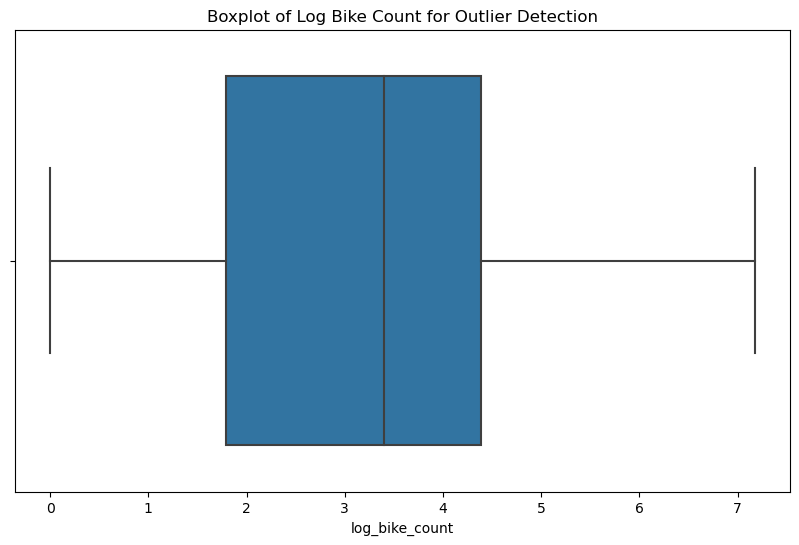

In [30]:
# outlier test
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['log_bike_count'])
plt.title('Boxplot of Log Bike Count for Outlier Detection')
plt.show()

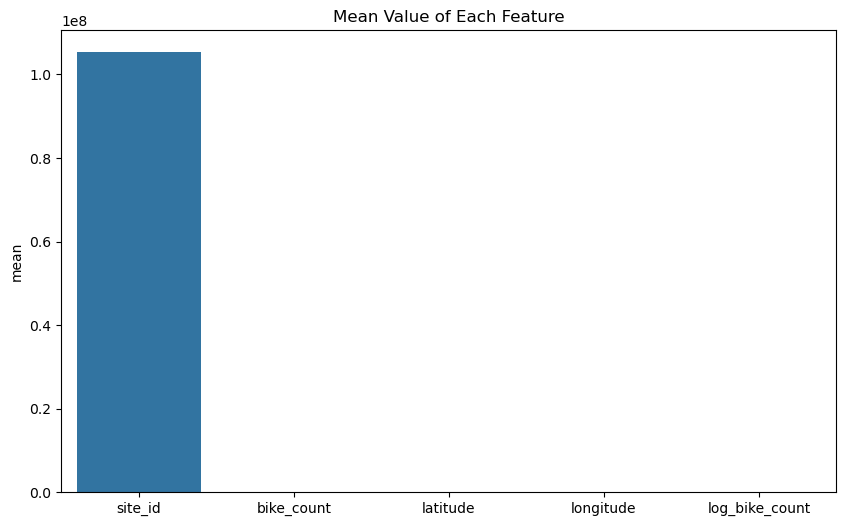

In [31]:
stats_df = data.describe().transpose()
plt.figure(figsize=(10, 6))
sns.barplot(x=stats_df.index, y=stats_df['mean'])
plt.title('Mean Value of Each Feature')
plt.show()

/var/folders/3c/7ww0mhtj5s11vrq1wd4k_6zm0000gn/T/ipykernel_14576/1807393047.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


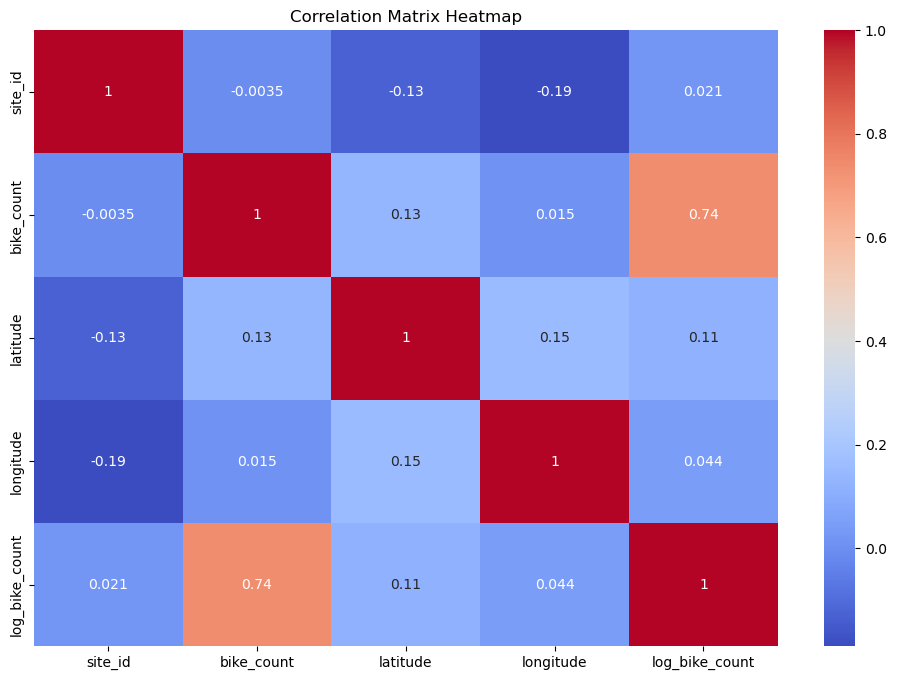

In [32]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [3]:
external=pd.read_csv("data/external_data.csv")
external.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


In [34]:
external.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 59 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   numer_sta  3322 non-null   int64  
 1   date       3322 non-null   object 
 2   pmer       3322 non-null   int64  
 3   tend       3322 non-null   int64  
 4   cod_tend   3322 non-null   int64  
 5   dd         3322 non-null   int64  
 6   ff         3322 non-null   float64
 7   t          3322 non-null   float64
 8   td         3322 non-null   float64
 9   u          3322 non-null   int64  
 10  vv         3322 non-null   int64  
 11  ww         3322 non-null   int64  
 12  w1         3315 non-null   float64
 13  w2         3312 non-null   float64
 14  n          3166 non-null   float64
 15  nbas       3317 non-null   float64
 16  hbas       2869 non-null   float64
 17  cl         2909 non-null   float64
 18  cm         1941 non-null   float64
 19  ch         1678 non-null   float64
 20  pres    

In [35]:
external['date'] = pd.to_datetime(external['date'])

earliest_date = external['date'].min()
latest_date = external['date'].max()

print("earliest date:", earliest_date)
print("latest date:", latest_date)

earliest date: 2020-09-01 00:00:00
latest date: 2021-10-21 12:00:00


In [9]:
final_data = pd.read_parquet(Path("data") / "final_test.parquet")
final_data.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429


In [38]:
final_data['date'] = pd.to_datetime(final_data['date'])

earliest_date_fi = final_data['date'].min()
latest_date_fi = final_data['date'].max()

print("earlisest date:", earliest_date_fi)
print("latest date:", latest_date_fi)

earlisest date: 2021-09-10 01:00:00
latest date: 2021-10-18 21:00:00


In [39]:
missing_percent=external.isnull().sum()/len(external)*100
missing_percent[missing_percent>50]
len(missing_percent[missing_percent>50])

20

# categorical columns pre-processing

In [73]:
category_cols = data.select_dtypes(include=['object', 'category']).columns
for col in category_cols:
    print(f"{col} has {data[col].nunique()} values")

counter_id has 56 values
counter_name has 56 values
site_name has 30 values
coordinates has 30 values
counter_technical_id has 30 values
installation_season has 3 values
current_season has 4 values


# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [49]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

In [50]:
data.groupby(['latitude', 'longitude'])['bike_count'].mean().reset_index()


,latitude,longitude,bike_count
0,48.826360,2.303030,48.719746
1,48.829523,2.386990,40.048195
2,48.830331,2.400551,23.401103
3,48.834210,2.265420,7.104246
4,48.834360,2.377000,54.010809
5,48.838480,2.375870,36.022287
6,48.839770,2.301980,58.326593
7,48.840801,2.333233,36.955787
8,48.842010,2.367290,75.166760
9,48.842230,2.368110,32.556441


/var/folders/3c/7ww0mhtj5s11vrq1wd4k_6zm0000gn/T/ipykernel_14576/3336499948.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=data['latitude'], y=data['longitude'], shade=True, cbar=True)


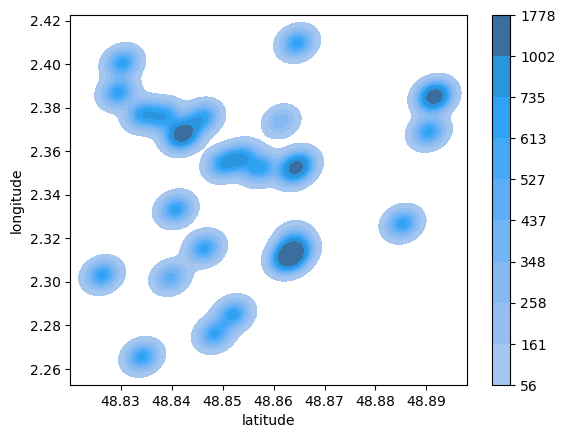

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# KDE
sns.kdeplot(x=data['latitude'], y=data['longitude'], shade=True, cbar=True)
plt.show()

Note that in this challenge, we consider only the 30 most frequented counting sites, to limit data size.

Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points:

<Axes: xlabel='date'>

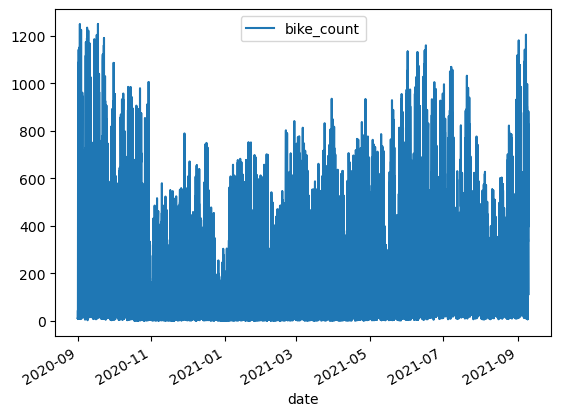

In [52]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture:

<Axes: xlabel='date'>

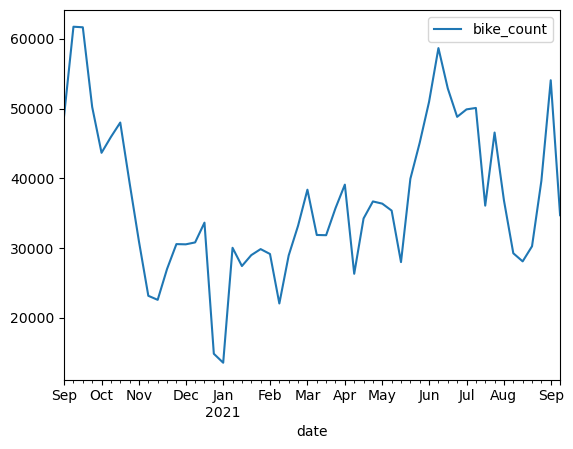

In [53]:
mask = (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")

data[mask].groupby(
    pd.Grouper(freq="1w", key="date")
)[["bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<Axes: xlabel='date'>

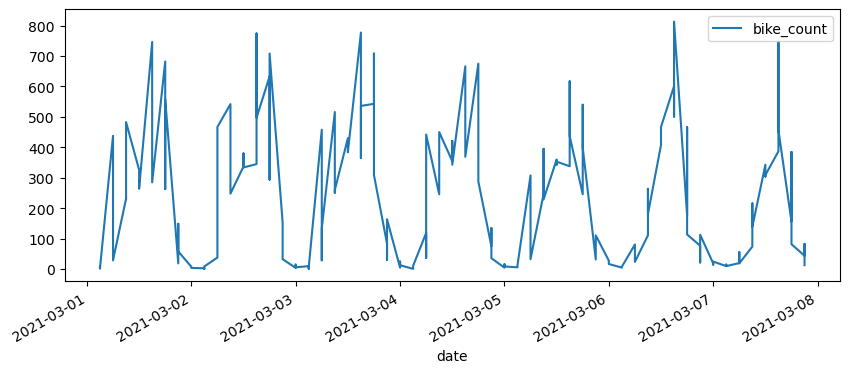

In [54]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

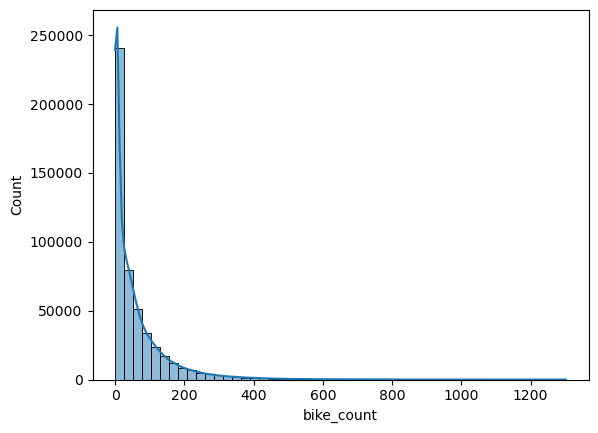

In [55]:
import seaborn as sns
ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

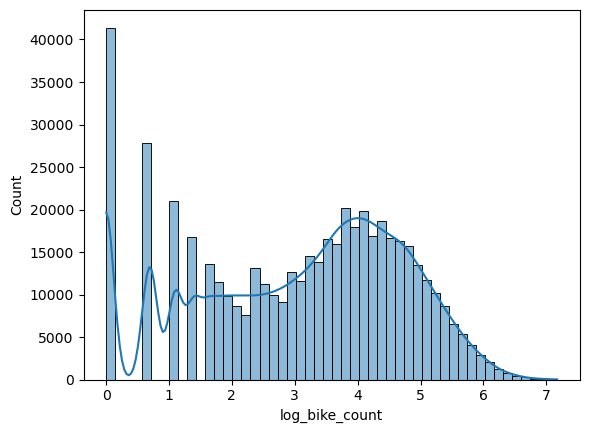

In [56]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [4]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [5]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

date_encoder = FunctionTransformer(_encode_dates, validate=False)

enc = OneHotEncoder(sparse_output=False)

Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

use one-hot encode for category columns

datetime process

In [59]:
data= _encode_dates(data)

In [60]:
import pandas as pd

data['counter_installation_date'] = pd.to_datetime(data['counter_installation_date'])

# Extracting time information
data['installation_year'] = data['counter_installation_date'].dt.year
data['installation_month'] = data['counter_installation_date'].dt.month
data['installation_day'] = data['counter_installation_date'].dt.day
data['installation_weekday'] = data['counter_installation_date'].dt.weekday  # Monday is 0 and Sunday is 6

# Creating new features
data['days_since_installation'] = (pd.to_datetime('today') - data['counter_installation_date']).dt.days

# Converting date to season (assuming a Northern Hemisphere perspective)
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}
data['installation_season'] = data['installation_month'].map(seasons)
data['current_season']=data['month'].map(seasons)

# Displaying the updated DataFrame
print(data)


                 counter_id                counter_name    site_id  \
48321   100007049-102007049    28 boulevard Diderot E-O  100007049   
48324   100007049-102007049    28 boulevard Diderot E-O  100007049   
48327   100007049-102007049    28 boulevard Diderot E-O  100007049   
48330   100007049-102007049    28 boulevard Diderot E-O  100007049   
48333   100007049-102007049    28 boulevard Diderot E-O  100007049   
...                     ...                         ...        ...   
929175  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929178  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929181  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929184  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929187  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   

                   site_name  bike_count counter_installation_date  \
48321   28 boulevard Diderot         0.0                2013-01-18   
48324   28 boulevar

In [61]:
# Use pd.get_dummies for one-hot encoding
encode_counter = pd.get_dummies(data['counter_name'], prefix='counter')
encode_site = pd.get_dummies(data['site_name'], prefix='site')
encode_season =pd.get_dummies(data['current_season'],prefix='season')
encode_install_season = pd.get_dummies(data['installation_season'],prefix='install_season')

# Concatenate the encoded features
encoded_features = pd.concat([encode_counter, encode_site,encode_season,encode_install_season], axis=1)

# Concatenate the encoded DataFrame with the original data
df_encoded_2 = pd.concat([data.drop(['counter_name','counter_id','site_id', 'site_name','current_season','installation_season'], axis=1), encoded_features], axis=1)

df_encoded_2.drop(columns=['bike_count','counter_installation_date','counter_technical_id','coordinates'],inplace=True)
df_encoded_2.head()

,latitude,longitude,log_bike_count,year,month,day,weekday,hour,installation_year,installation_month,...,site_Totem 85 quai d'Austerlitz,site_Totem Cours la Reine,site_Voie Georges Pompidou,season_Fall,season_Spring,season_Summer,season_Winter,install_season_Fall,install_season_Summer,install_season_Winter
48321,48.846028,2.375429,0.000000,2020,9,1,1,3,2013,1,...,0,0,0,1,0,0,0,0,0,1
48324,48.846028,2.375429,0.693147,2020,9,1,1,3,2013,1,...,0,0,0,1,0,0,0,0,0,1
48327,48.846028,2.375429,0.000000,2020,9,1,1,3,2013,1,...,0,0,0,1,0,0,0,0,0,1
48330,48.846028,2.375429,1.609438,2020,9,1,1,15,2013,1,...,0,0,0,1,0,0,0,0,0,1
48333,48.846028,2.375429,2.302585,2020,9,1,1,18,2013,1,...,0,0,0,1,0,0,0,0,0,1


# model selection

In [10]:
from sklearn.model_selection import train_test_split

X = df_encoded_2.drop('log_bike_count', axis=1) # 或其他目标变量
y = df_encoded_2['log_bike_count']

#train_size_xgb = 8 * 30
train_size = int(len(df_encoded_2) * 0.8)

train, test = df_encoded_2[:train_size], df_encoded_2[train_size:]

X_train = train.drop('log_bike_count', axis=1)
y_train = train['log_bike_count']
X_test = test.drop('log_bike_count', axis=1)
y_test = test['log_bike_count']


# linear model

In [11]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(df_encoded_2[["hour"]])


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge

regressor = Ridge()

pipe = regressor
pipe.fit(X_train, y_train)

Ridge()

In [14]:
from sklearn.metrics import mean_squared_error

y_pred_lm=pipe.predict(X_test)

rmse_lm = np.sqrt(mean_squared_error(y_test, y_pred_lm))
print(f"Test RMSE: {rmse_lm}")

Test RMSE: 1.7897617815065088


# random forest

In [16]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

predictions_rf = model_rf.predict(X_test)


In [18]:
rmse_rf = np.sqrt(mean_squared_error(y_test, predictions_rf))
print(f"Test RMSE: {rmse_rf}")

Test RMSE: 1.1358449942604882


# XGBoost

In [19]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 5,
    'eta': 0.1,
    'min_child_weight': 1,
    'subsample':  0.7,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

bst = xgb.train(params, dtrain, num_boost_round=100)


In [20]:
from sklearn.metrics import mean_squared_error

y_pred_xgb = bst.predict(dtest)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"Test RMSE: {rmse_xgb}")


Test RMSE: 1.116677553617002


# SARIMA 

In [65]:
import statsmodels.api as sm

p, d, q = 1, 1, 1  
P, D, Q, m = 1, 1, 1, 12  


sarima_model = sm.tsa.statespace.SARIMAX(y_train,
                                          order=(p, d, q),
                                          seasonal_order=(P, D, Q, m),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)


sarima_results = sarima_model.fit()

y_pred_sarima = sarima_results.predict(start=test.index[0], end=test.index[-1])

# 可以通过以下代码查看模型的诊断图
#sarima_results.plot_diagnostics()

/Users/rongshen/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rongshen/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03850D+00    |proj g|=  2.35512D-01

At iterate    5    f=  1.76282D+00    |proj g|=  2.69448D-02

At iterate   10    f=  1.75821D+00    |proj g|=  8.64458D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     24      1     0     0   3.911D-05   1.758D+00
  F =   1.7582133943664913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


: 

In [ ]:
rmse_sarima = np.sqrt(mean_squared_error(y_test, y_pred_sarima))
print(f"Test RMSE: {rmse_sarima}")

# LSTM

In [ ]:
log_bike_count = np.array(df_encoded_2['log_bike_count'])

def create_dataset(data, n_input):
    X, y = [], []
    for i in range(len(data)):
        
        end_ix = i + n_input
        
        if end_ix > len(data)-1:
            break
        
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_input = 12


X, y = create_dataset(log_bike_count, n_input)


n_features = 1  
X_lstm = X.reshape((X.shape[0], X.shape[1], n_features))


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense


model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')


model_lstm.fit(X, y, epochs=200, verbose=0)


model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred_lstm = model_lstm.predict(X_test)

mse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
rmse_lstm = mse_lstm ** 0.5
print(f"Test RMSE: {rmse_lstm")

# model result

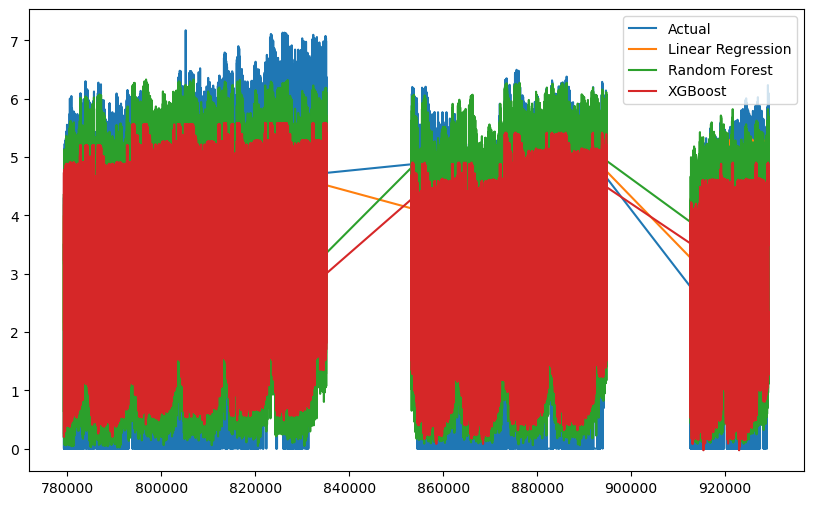

In [22]:
# visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_lm, label='Linear Regression')
plt.plot(y_test.index, predictions_rf, label='Random Forest')
plt.plot(y_test.index, y_pred_xgb, label='XGBoost')
#plt.plot(y_test.index, y_pred_lstm, label='LSTM')
#plt.plot(y_test.index, sarima_predictions, label='SARIMA')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest','XGBoost'],
    'RMSE': [rmse_lm, rmse_rf, rmse_xgb]
})

results.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

print(results)

               Model      RMSE
0  Linear Regression  1.789762
1      Random Forest  1.135845
2            XGBoost  1.116678


# Merged data

In [6]:
data2 = pd.read_parquet(Path("data") / "train.parquet")


In [7]:
#convert to standard time format
data2['date'] = pd.to_datetime(data2['date'])
data2['date'] = data2['date'].dt.round('3H')
external['date'] = pd.to_datetime(external['date'])

# merging on the timestamp column
merged_data = pd.merge(data2, external, left_on='date', right_on='date', how='left')

In [10]:
#convert to standard time format
final_data['date'] = pd.to_datetime(final_data['date'])
final_data['date'] = final_data['date'].dt.round('3H')
#external['date'] = pd.to_datetime(external['date'])

# merging on the timestamp column
merged_data_final = pd.merge(final_data, external, left_on='date', right_on='date', how='left')

In [11]:
merge_miss = merged_data.isnull().sum()/len(merged_data)*100
column_to_drop=merge_miss[merge_miss>50].index

merge_miss_final = merged_data_final.isnull().sum()/len(merged_data_final)*100
column_to_drop_final=merge_miss_final[merge_miss_final>50].index

In [12]:
merged_data.drop(columns=column_to_drop,inplace=True)

merged_data_final.drop(columns=column_to_drop_final,inplace=True)

In [13]:
correlation = merged_data.corr()
correlation_target = abs(correlation['log_bike_count'])
low_corr_fea=correlation_target[correlation_target<0.02].index
merged_data.drop(columns=low_corr_fea,inplace=True)
print(merged_data.columns.tolist()[:])

correlation_final = merged_data.corr()
correlation_target_final = abs(correlation_final['log_bike_count'])
low_corr_fea_final=correlation_target_final[correlation_target_final<0.02].index
merged_data_final.drop(columns=low_corr_fea_final,inplace=True)
print(merged_data_final.columns.tolist()[:])

/var/folders/3c/7ww0mhtj5s11vrq1wd4k_6zm0000gn/T/ipykernel_24987/4172520454.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = merged_data.corr()


['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count', 'date', 'counter_installation_date', 'coordinates', 'counter_technical_id', 'latitude', 'longitude', 'log_bike_count', 'numer_sta', 'pmer', 'cod_tend', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'cl', 'pres', 'raf10', 'rafper', 'per', 'etat_sol', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'nnuage1', 'ctype1', 'nnuage2', 'hnuage2']


/var/folders/3c/7ww0mhtj5s11vrq1wd4k_6zm0000gn/T/ipykernel_24987/4172520454.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_final = merged_data.corr()


['counter_id', 'counter_name', 'site_id', 'site_name', 'date', 'counter_installation_date', 'coordinates', 'counter_technical_id', 'latitude', 'longitude', 'numer_sta', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'tend24', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'nnuage1', 'ctype1', 'hnuage1', 'nnuage2', 'hnuage2']


/var/folders/3c/7ww0mhtj5s11vrq1wd4k_6zm0000gn/T/ipykernel_24987/451814299.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_data.corr(), annot=True, fmt=".2f")


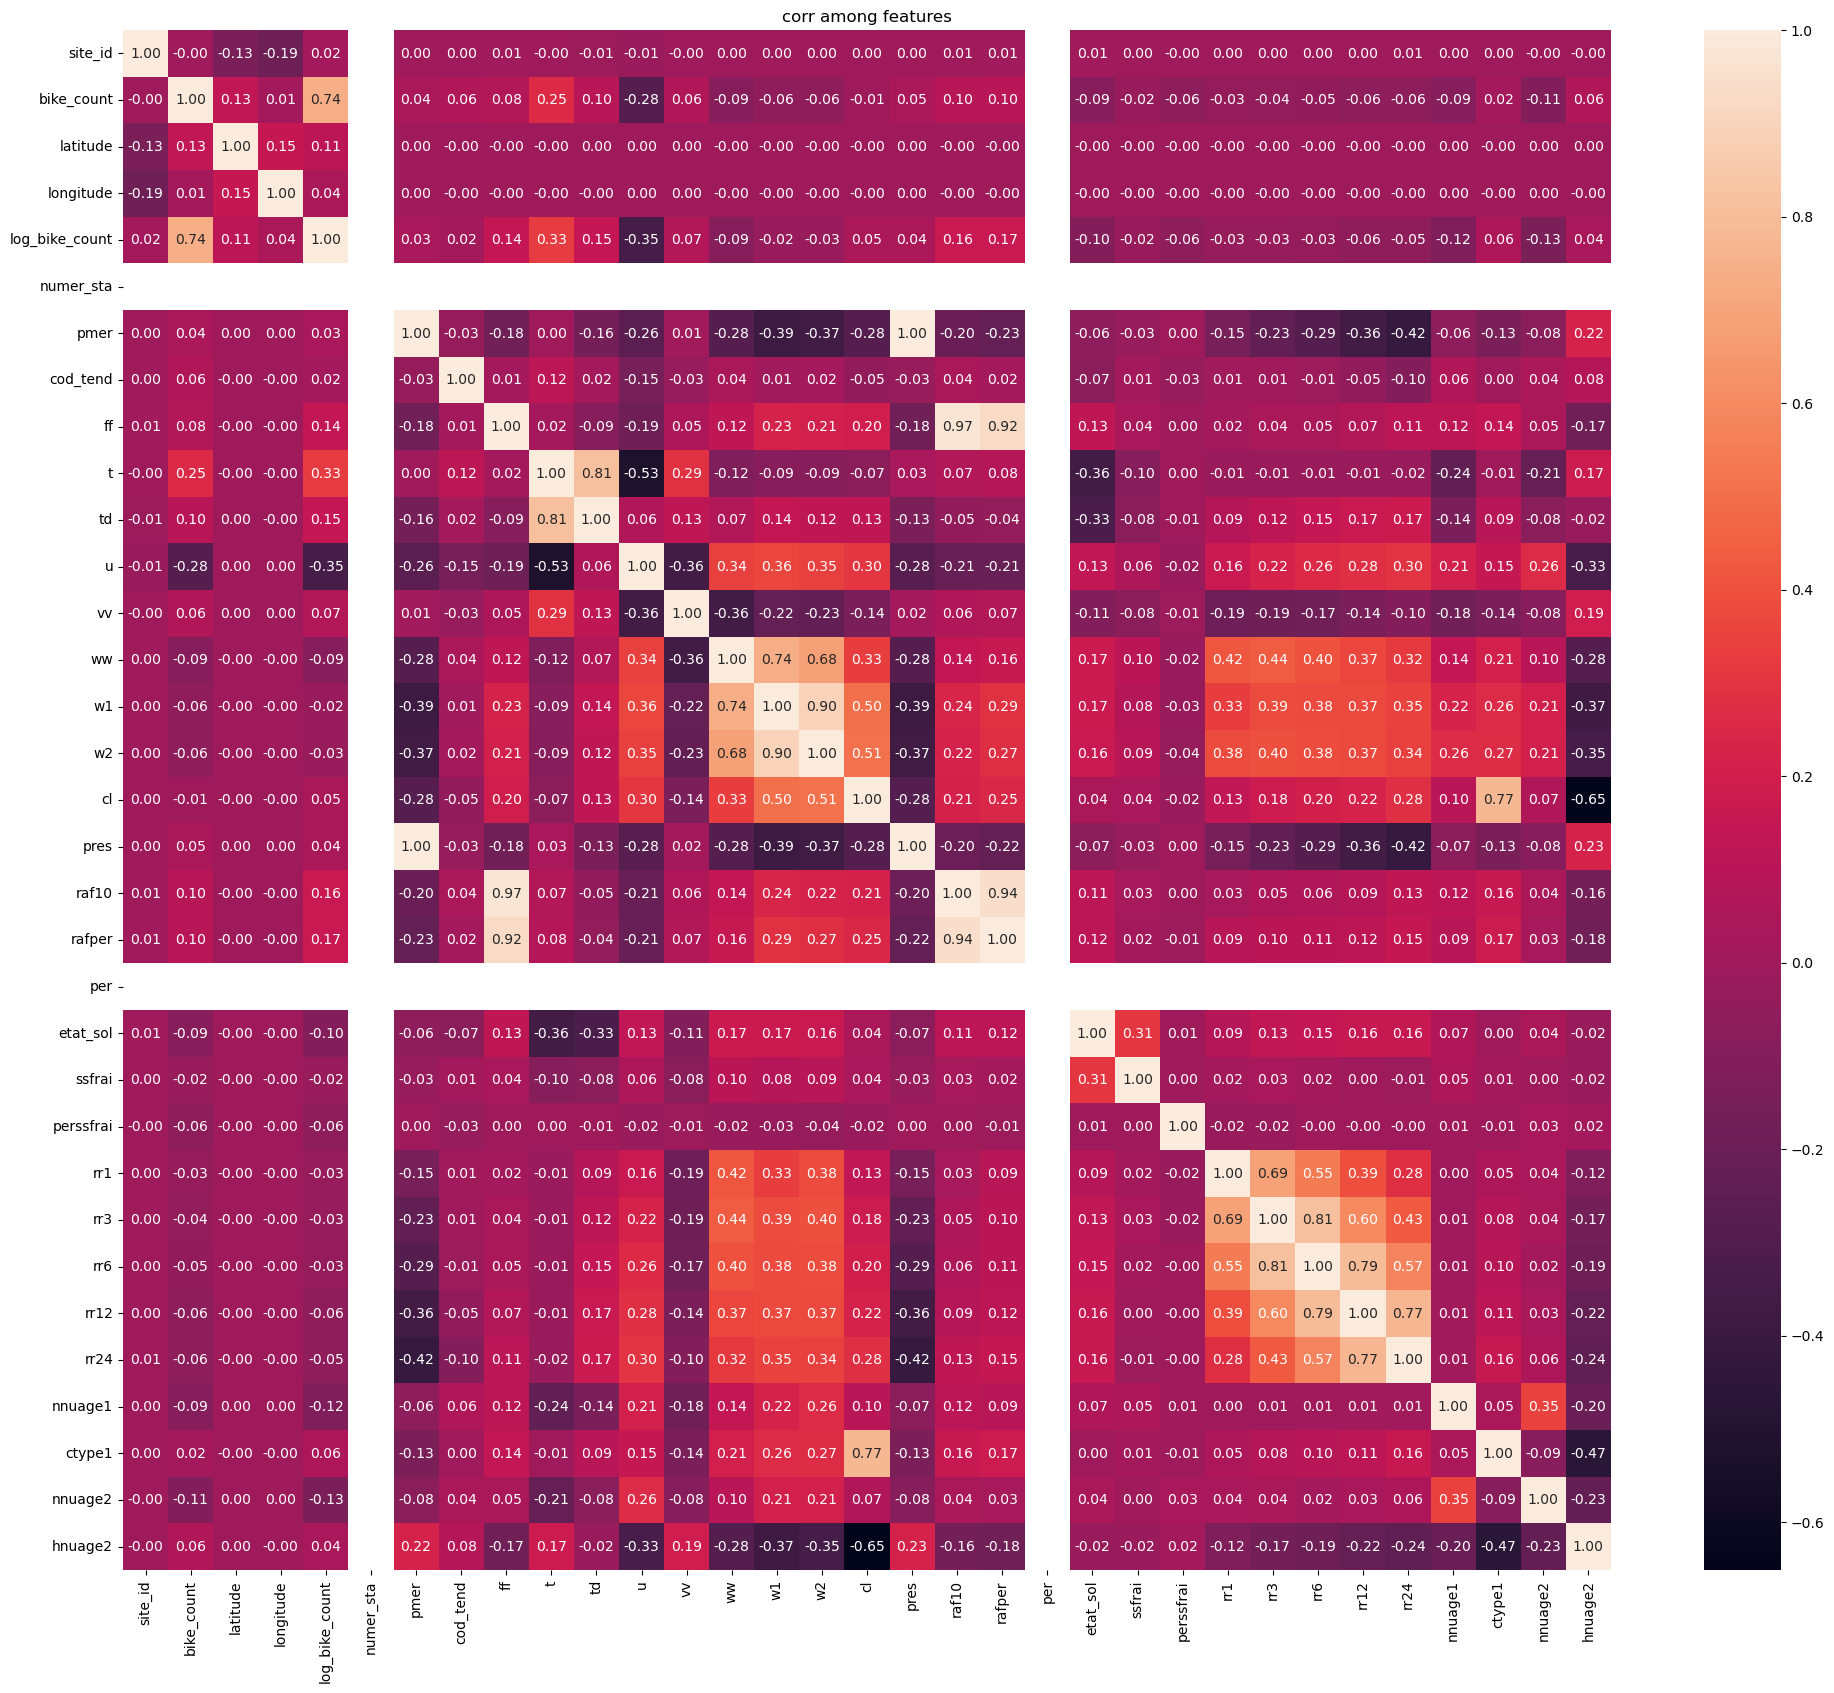

In [14]:
import seaborn as sns
plt.figure(figsize=(24, 20))
sns.heatmap(merged_data.corr(), annot=True, fmt=".2f")
plt.title('corr among features')
plt.show()

In [15]:
column_to_drop2=['counter_id', 'site_id','coordinates','counter_technical_id','numer_sta', 'pmer', 'cod_tend', 'td', 'ww', 'w1', 'w2', 'cl', 'pres', 'raf10', 'ff', 'per', 'ssfrai', 'rr1', 'rr6', 'rr12', 'rr24', 'nnuage1', 'ctype1', 'rr3', 'nnuage2', 'hnuage2']
merged_data.drop(columns=column_to_drop2,inplace=True)
print(merged_data.columns.tolist()[:])

common_columns = merged_data.columns.intersection(merged_data_final.columns)
merged_data_final = merged_data_final[common_columns]

print(merged_data_final.columns.tolist()[:])

['counter_name', 'site_name', 'bike_count', 'date', 'counter_installation_date', 'latitude', 'longitude', 'log_bike_count', 't', 'u', 'vv', 'rafper', 'etat_sol', 'perssfrai']
['counter_name', 'site_name', 'date', 'counter_installation_date', 'latitude', 'longitude', 't', 'u', 'vv', 'rafper', 'etat_sol', 'perssfrai']


/var/folders/3c/7ww0mhtj5s11vrq1wd4k_6zm0000gn/T/ipykernel_24987/1346243518.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_data.corr(), annot=True, fmt=".2f")


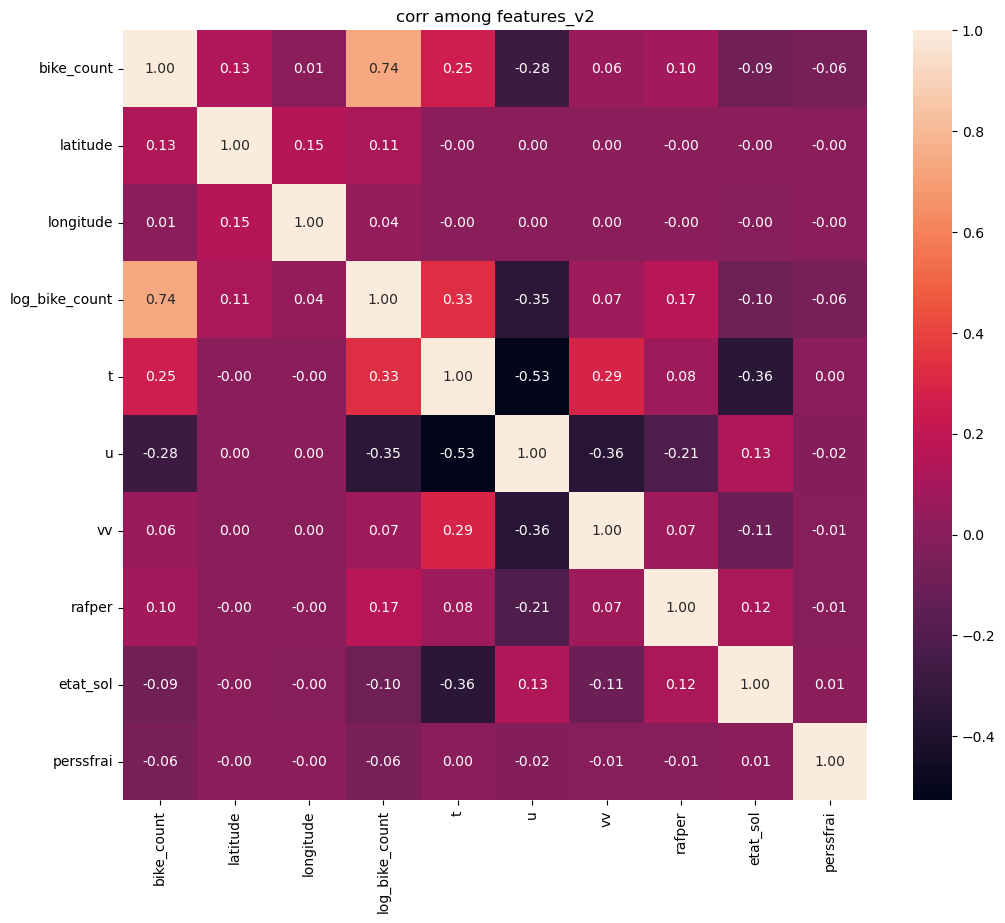

In [16]:
plt.figure(figsize=(12, 10))
sns.heatmap(merged_data.corr(), annot=True, fmt=".2f")
plt.title('corr among features_v2')
plt.show()

In [17]:
merged_data= _encode_dates(merged_data)

In [19]:
import pandas as pd

merged_data['counter_installation_date'] = pd.to_datetime(merged_data['counter_installation_date'])

# Extracting time information
merged_data['installation_year'] = merged_data['counter_installation_date'].dt.year
merged_data['installation_month'] = merged_data['counter_installation_date'].dt.month
merged_data['installation_day'] = merged_data['counter_installation_date'].dt.day
merged_data['installation_weekday'] = merged_data['counter_installation_date'].dt.weekday  

# Creating new features
merged_data['days_since_installation'] = (pd.to_datetime('today') - merged_data['counter_installation_date']).dt.days

# Converting date to season (assuming a Northern Hemisphere perspective)
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}
merged_data['installation_season'] = merged_data['installation_month'].map(seasons)
merged_data['current_season']=merged_data['month'].map(seasons)

# Displaying the updated DataFrame
print(merged_data)


                      counter_name             site_name  bike_count  \
0         28 boulevard Diderot E-O  28 boulevard Diderot         0.0   
1         28 boulevard Diderot E-O  28 boulevard Diderot         1.0   
2         28 boulevard Diderot E-O  28 boulevard Diderot         0.0   
3         28 boulevard Diderot E-O  28 boulevard Diderot         4.0   
4         28 boulevard Diderot E-O  28 boulevard Diderot         9.0   
...                            ...                   ...         ...   
496984  254 rue de Vaugirard SO-NE  254 rue de Vaugirard       445.0   
496985  254 rue de Vaugirard SO-NE  254 rue de Vaugirard       145.0   
496986  254 rue de Vaugirard SO-NE  254 rue de Vaugirard       218.0   
496987  254 rue de Vaugirard SO-NE  254 rue de Vaugirard        21.0   
496988  254 rue de Vaugirard SO-NE  254 rue de Vaugirard        15.0   

       counter_installation_date   latitude  longitude  log_bike_count  \
0                     2013-01-18  48.846028   2.375429       

In [20]:
# Use pd.get_dummies for one-hot encoding
merged_encode_counter = pd.get_dummies(merged_data['counter_name'], prefix='counter')
merged_encode_site = pd.get_dummies(merged_data['site_name'], prefix='site')
merged_encode_season =pd.get_dummies(merged_data['current_season'],prefix='season')
merged_encode_install_season = pd.get_dummies(merged_data['installation_season'],prefix='install_season')

# Concatenate the encoded features
merged_encoded_features = pd.concat([merged_encode_counter, merged_encode_site,merged_encode_season,merged_encode_install_season], axis=1)

# Concatenate the encoded DataFrame with the original data
merged_df_encoded_2 = pd.concat([merged_data.drop(['counter_name', 'site_name','current_season','installation_season'], axis=1), merged_encoded_features], axis=1)

merged_df_encoded_2.drop(columns=['bike_count','counter_installation_date'],inplace=True)
merged_df_encoded_2.head()

,latitude,longitude,log_bike_count,t,u,vv,rafper,etat_sol,perssfrai,year,...,site_Totem 85 quai d'Austerlitz,site_Totem Cours la Reine,site_Voie Georges Pompidou,season_Fall,season_Spring,season_Summer,season_Winter,install_season_Fall,install_season_Summer,install_season_Winter
0,48.846028,2.375429,0.000000,283.95,88.0,25000.0,1.5,0.0,-30.0,2020,...,0,0,0,1,0,0,0,0,0,1
1,48.846028,2.375429,0.693147,283.95,88.0,25000.0,1.5,0.0,-30.0,2020,...,0,0,0,1,0,0,0,0,0,1
2,48.846028,2.375429,0.000000,283.95,88.0,25000.0,1.5,0.0,-30.0,2020,...,0,0,0,1,0,0,0,0,0,1
3,48.846028,2.375429,1.609438,293.65,41.0,30000.0,7.5,0.0,-30.0,2020,...,0,0,0,1,0,0,0,0,0,1
4,48.846028,2.375429,2.302585,292.15,47.0,30000.0,6.5,0.0,-60.0,2020,...,0,0,0,1,0,0,0,0,0,1


In [21]:
print(merged_df_encoded_2.isnull().sum())

latitude                   0
longitude                  0
log_bike_count             0
t                        666
u                        666
                        ... 
season_Summer              0
season_Winter              0
install_season_Fall        0
install_season_Summer      0
install_season_Winter      0
Length: 112, dtype: int64


In [22]:
merged_df_encoded_2 =merged_df_encoded_2.dropna()


# model selection

In [23]:
from sklearn.model_selection import train_test_split

#train_size_xgb = 8 * 30
train_size = int(len(merged_df_encoded_2) * 0.8)

train, test = merged_df_encoded_2[:train_size], merged_df_encoded_2[train_size:]

X2_train = train.drop('log_bike_count', axis=1)
y2_train = train['log_bike_count']
X2_test = test.drop('log_bike_count', axis=1)
y2_test = test['log_bike_count']


# linear model

In [24]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(merged_df_encoded_2[["hour"]])

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge

regressor = Ridge()

pipe2 = regressor
pipe2.fit(X2_train, y2_train)

Ridge()

In [26]:
from sklearn.metrics import mean_squared_error

y2_pred_lm=pipe2.predict(X2_test)

rmse2_lm = np.sqrt(mean_squared_error(y2_test, y2_pred_lm))
print(f"Test RMSE: {rmse2_lm}")

Test RMSE: 1.6406033217023765


# Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

model2_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model2_rf.fit(X2_train, y2_train)

y2_pred_rf = model2_rf.predict(X2_test)


In [30]:
rmse2_rf = np.sqrt(mean_squared_error(y2_test, y2_pred_rf))
print(f"Test RMSE: {rmse2_rf}")

Test RMSE: 1.1942760960599943


# XGBoost

In [60]:
import xgboost as xgb

dtrain2 = xgb.DMatrix(X2_train, label=y2_train)
dtest2 = xgb.DMatrix(X2_test, label=y2_test)

params = {
    'max_depth':15,
    'eta': 0.1,
    'min_child_weight': 3,
    'subsample':  0.7,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

bst2 = xgb.train(params, dtrain2, num_boost_round=100)


In [61]:
from sklearn.metrics import mean_squared_error

y2_pred_xgb = bst2.predict(dtest2)

rmse2_xgb = np.sqrt(mean_squared_error(y2_test, y2_pred_xgb))
print(f"Test RMSE: {rmse2_xgb}")

Test RMSE: 1.1562317278777465


# model result

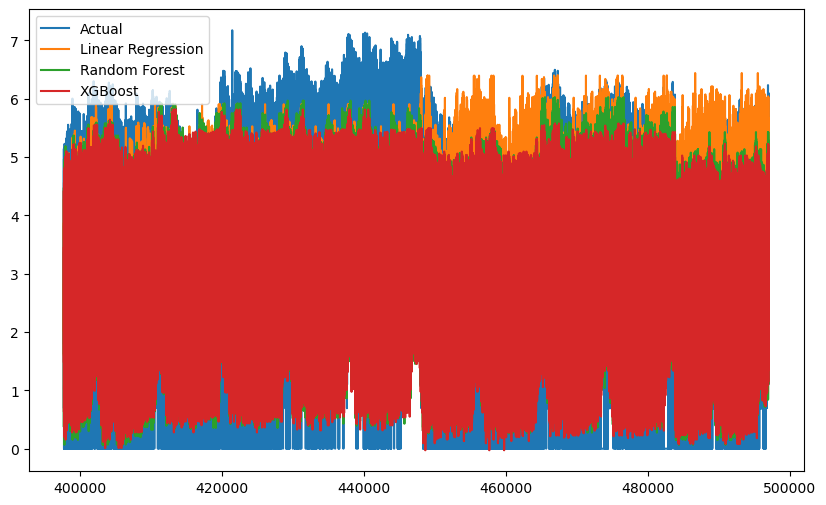

In [62]:
# visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y2_test.index, y2_test, label='Actual')
plt.plot(y2_test.index, y2_pred_lm, label='Linear Regression')
plt.plot(y2_test.index, y2_pred_rf, label='Random Forest')
plt.plot(y2_test.index, y2_pred_xgb, label='XGBoost')
#plt.plot(y_test.index, y_pred_lstm, label='LSTM')
#plt.plot(y_test.index, sarima_predictions, label='SARIMA')
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error

results2 = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest','XGBoost'],
    'RMSE': [rmse2_lm, rmse2_rf, rmse2_xgb]
})

results2.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

print(results2)

               Model      RMSE
0  Linear Regression  1.640603
1      Random Forest  1.194276
2            XGBoost  1.156232
